In [2]:
!pip install yfinance matplotlib pandas numpy arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 12.1 MB/s eta 0:00:00


In [1]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/Diffusion-TS')

Mounted at /content/drive


/tmp/ipython-input-692161666.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  years = pd.date_range(start='1999', periods=len(df), freq='Q')


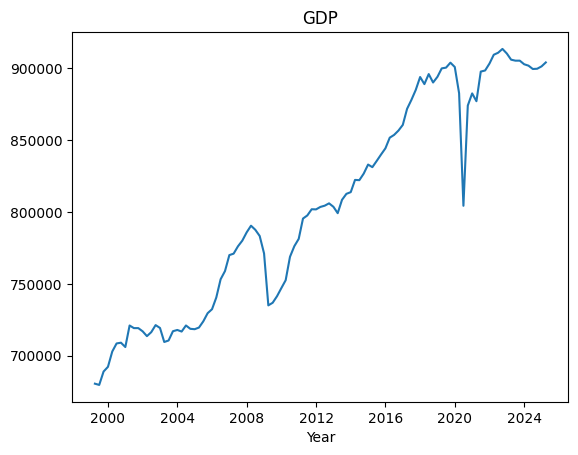

/tmp/ipython-input-692161666.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  years = pd.date_range(start='1999', periods=len(df), freq='Q')


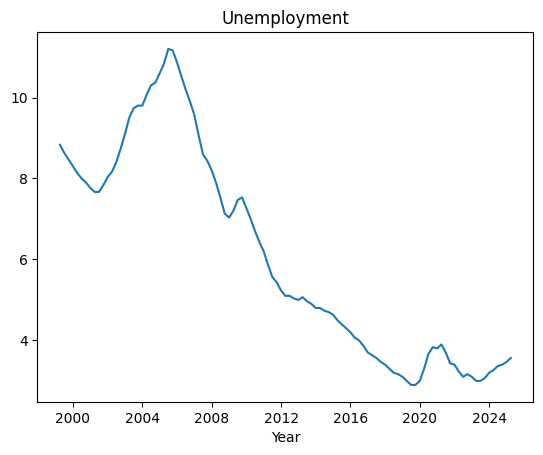

/tmp/ipython-input-692161666.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  years = pd.date_range(start='1999', periods=len(df), freq='Q')


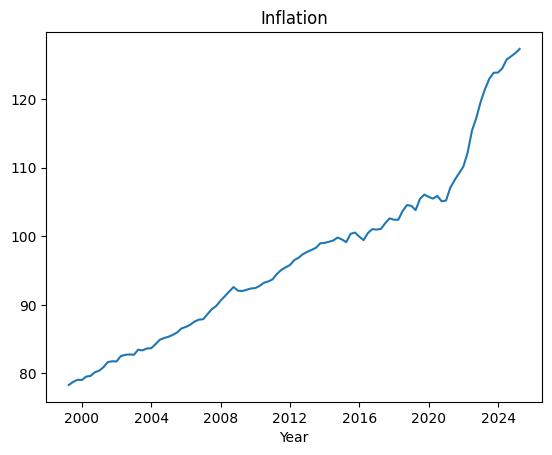

/tmp/ipython-input-692161666.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  years = pd.date_range(start='1999', periods=len(df), freq='Q')


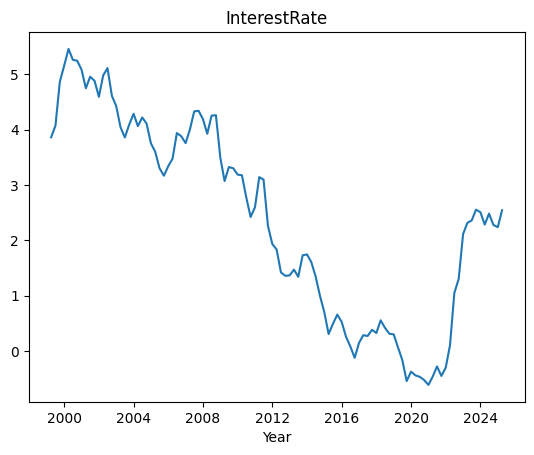

/tmp/ipython-input-692161666.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  years = pd.date_range(start='1999', periods=len(df), freq='Q')


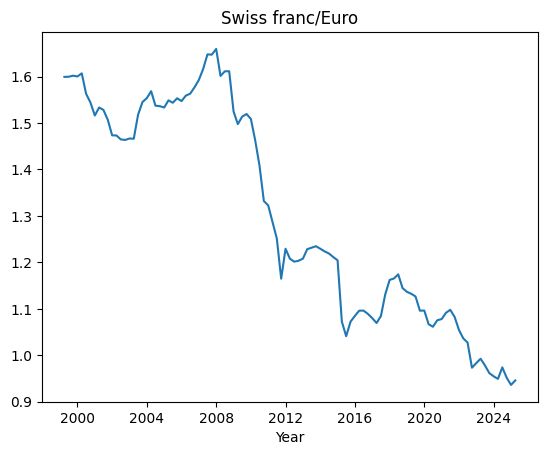

/tmp/ipython-input-692161666.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  years = pd.date_range(start='1999', periods=len(df), freq='Q')


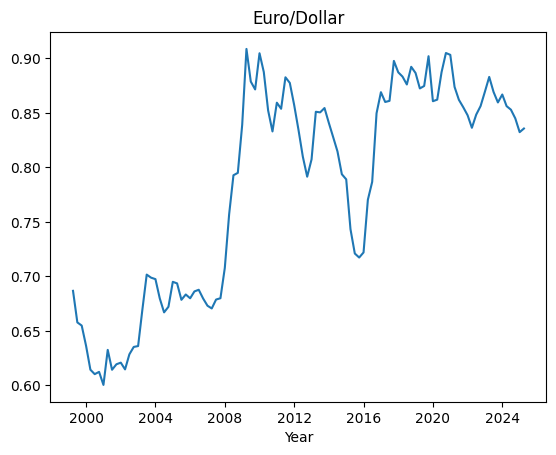

/tmp/ipython-input-692161666.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  years = pd.date_range(start='1999', periods=len(df), freq='Q')


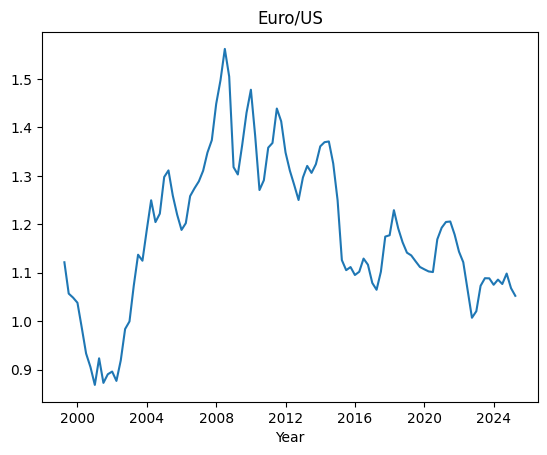

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def compute_stress_metrics(df, window=4):
    returns = df.pct_change()
    volatility = returns.rolling(window).std()
    rolling_max = df.cummax()
    drawdown = df / rolling_max - 1
    mean_ret = returns.rolling(window).mean()
    std_ret = returns.rolling(window).std()
    zscore = (returns - mean_ret) / std_ret
    return {'volatility': volatility, 'drawdown': drawdown, 'zscore': zscore}

def identify_stress_periods(metrics, vol_thresh, dd_thresh, z_thresh):
    vol = metrics['volatility'] > vol_thresh
    dd = metrics['drawdown'] < dd_thresh
    z = metrics['zscore'] < z_thresh
    return vol | dd | z

def plot_stress(df, stress_periods):

    years = pd.date_range(start='1999', periods=len(df), freq='Q')
    for col in df.columns:
        fig, ax = plt.subplots()
        ax.plot(years, df[col], label=col)
        ax.fill_between(years, df[col].min(), df[col].max(),
                        where=stress_periods[col].values, alpha=0.3, label='Stress')
        ax.set_title(f"{col} with Stress Periods")
        ax.legend()
        ax.set_xlabel("Year")
        plt.show()

df = pd.read_csv('/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Data/germany_macro.csv', parse_dates=False)
metrics = compute_stress_metrics(df, window=4)
q = 0.99
vol_tresh = metrics['volatility'].quantile(q)
dd_thresh = metrics['drawdown'].quantile(1-q)
z_thresh = metrics['zscore'].quantile(1-q)
stress_flags = identify_stress_periods(metrics, vol_thresh= vol_tresh, dd_thresh= dd_thresh, z_thresh= z_thresh)

for col in df.columns:
  plot_stress(df[[col]], stress_flags[[col]])

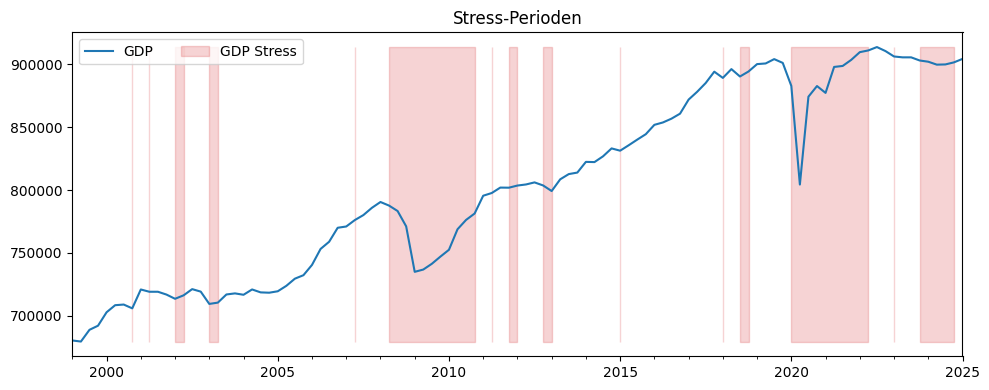

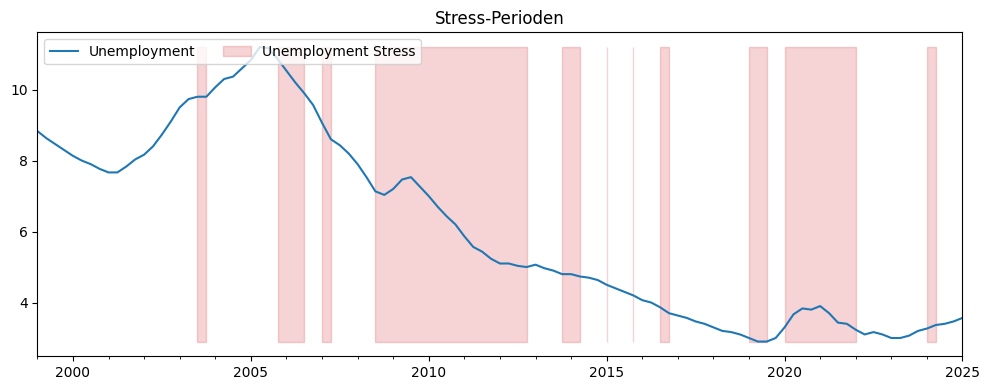

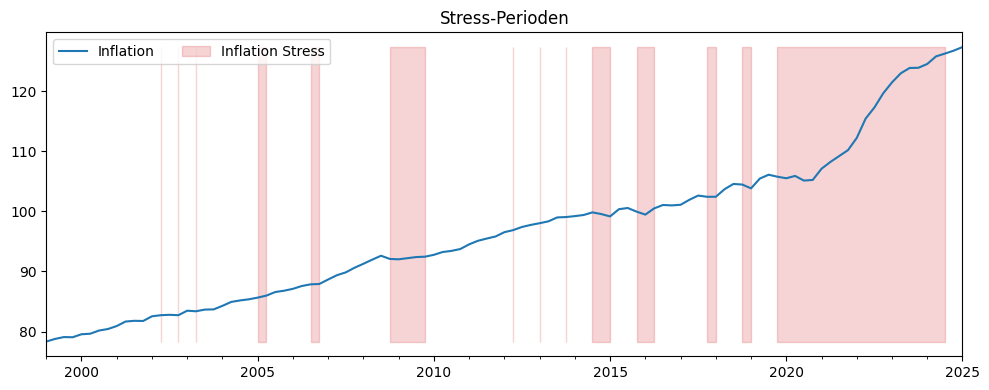

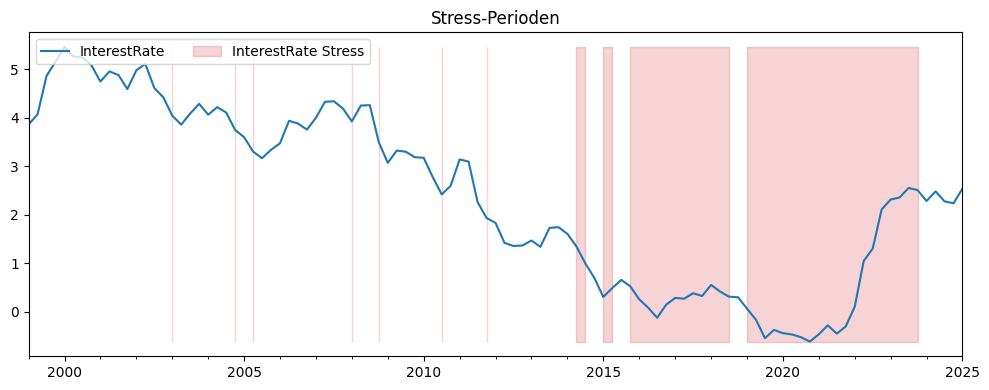

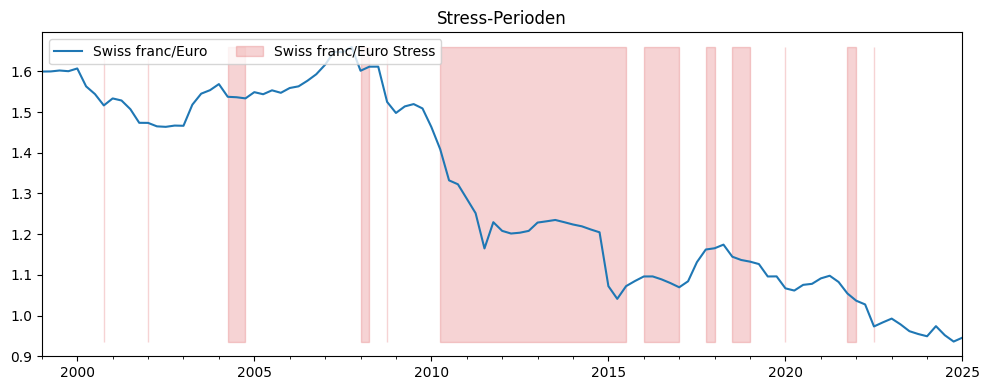

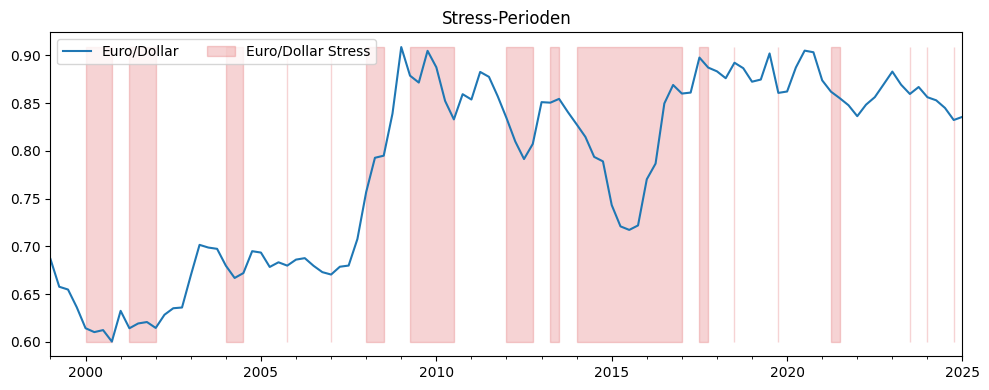

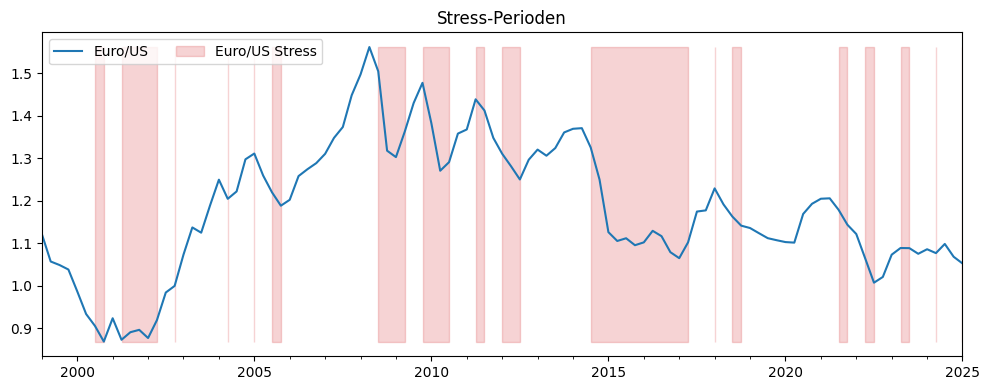

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_stress_metrics(df, window=4, ret_horizon=4, dd_window=20, eps=1e-8):
    """
    window: Rollfenster (z. B. 4 Quartale = 1 Jahr)
    ret_horizon: 4 -> YoY-Veränderung für Quartalsdaten
    dd_window: Fenster für rollierendes Maximum (z. B. 20 Quartale = 5 Jahre)
    """
    X = df.select_dtypes(include=[np.number]).copy()

    # YoY-Veränderung statt QoQ-Return (für Makro oft sinnvoller)
    returns = X.pct_change(ret_horizon)

    # Volatilität & Z-Score auf returns
    vol = returns.rolling(window, min_periods=window).std()
    mu  = returns.rolling(window, min_periods=window).mean()
    sigma = returns.rolling(window, min_periods=window).std().clip(lower=eps)
    z = (returns - mu) / sigma

    # Drawdown relativ zu rollierendem Max der Niveaus
    roll_max = X.rolling(dd_window, min_periods=1).max()
    dd = X / roll_max - 1

    return {'volatility': vol, 'drawdown': dd, 'zscore': z}

def identify_stress_periods(metrics, q=0.8, require_n=1):
    vol = metrics['volatility']
    dd  = metrics['drawdown']
    z   = metrics['zscore']

    vol_th = vol.quantile(q)
    dd_th  = dd.quantile(1 - q)
    z_th   = z.quantile(1 - q)

    c_vol = vol.gt(vol_th)   # hohe Volatilität
    c_dd  = dd.lt(dd_th)     # tiefer Drawdown
    c_z   = z.lt(z_th)       # negative Ausreißer

    # Optional: robustere Regel – mindestens 'require_n' von 3 Bedingungen
    cond_sum = c_vol.astype(int) + c_dd.astype(int) + c_z.astype(int)
    stress = cond_sum >= require_n
    return stress

def plot_stress(df, stress_flags, title_suffix=""):
    years = pd.date_range(start='1999', periods=len(df), freq='QE')
    df_indexed = df.set_index(years)
    stress_flags_indexed = stress_flags.set_index(years)

    ax = df_indexed.plot(figsize=(10,4), lw=1.5)
    y_min, y_max = df_indexed.min().min(), df_indexed.max().max()

    # Schattierung pro Spalte
    for col in df_indexed.columns:
        if col in stress_flags_indexed.columns:
            ax.fill_between(df_indexed.index, y_min, y_max,
                            where=stress_flags_indexed[col].fillna(False),
                            color='tab:red', alpha=0.2, label=f'{col} Stress')
    ax.set_title(f"Stress-Perioden {title_suffix}".strip())
    ax.set_xlabel("")
    ax.legend(loc='upper left', ncol=2)
    plt.tight_layout()
    plt.show()

df = pd.read_csv('/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Data/germany_macro.csv', parse_dates=False)
metrics = compute_stress_metrics(df, window=4)
q = 0.9
vol_tresh = metrics['volatility'].quantile(q)
dd_thresh = metrics['drawdown'].quantile(1-q)
z_thresh = metrics['zscore'].quantile(1-q)
stress_flags = identify_stress_periods(metrics)

for col in df.columns:
  plot_stress(df[[col]], stress_flags[[col]])

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.435e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


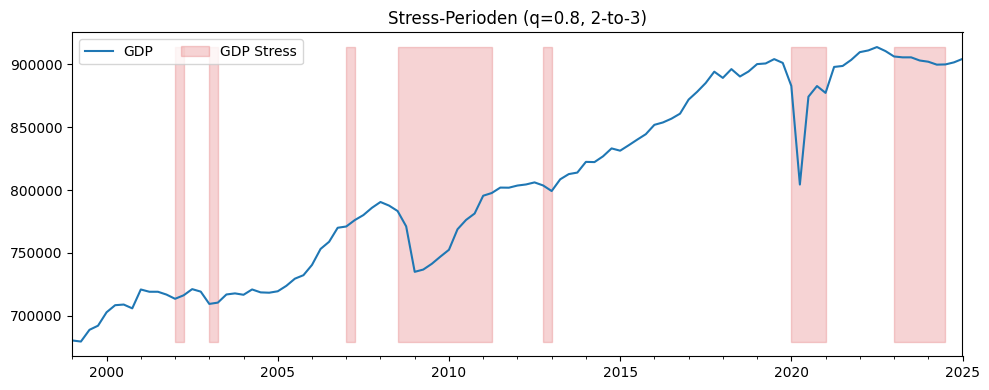

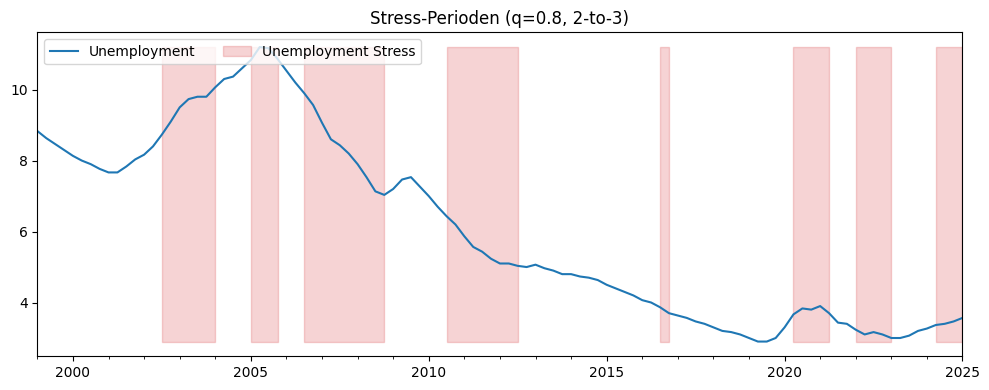

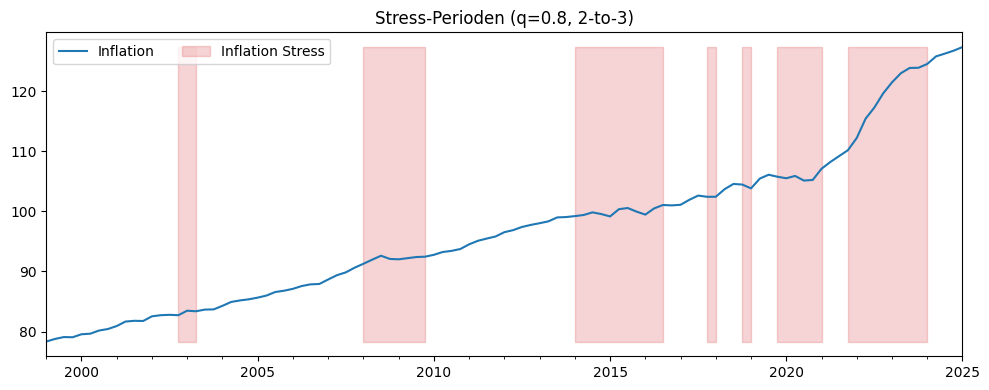

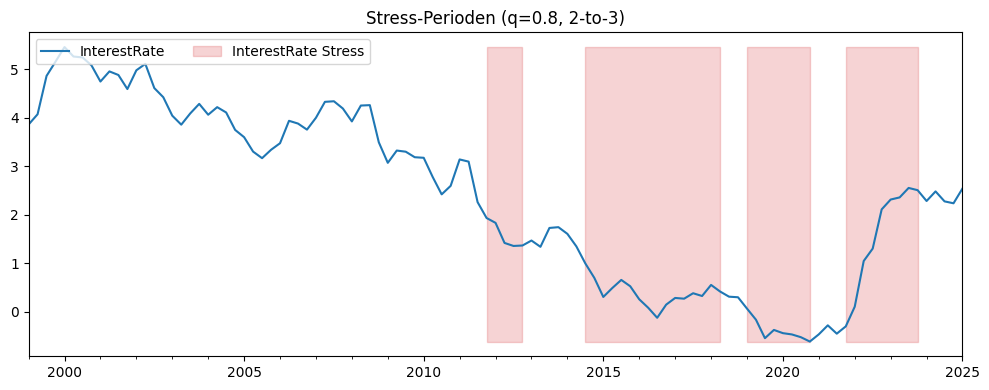

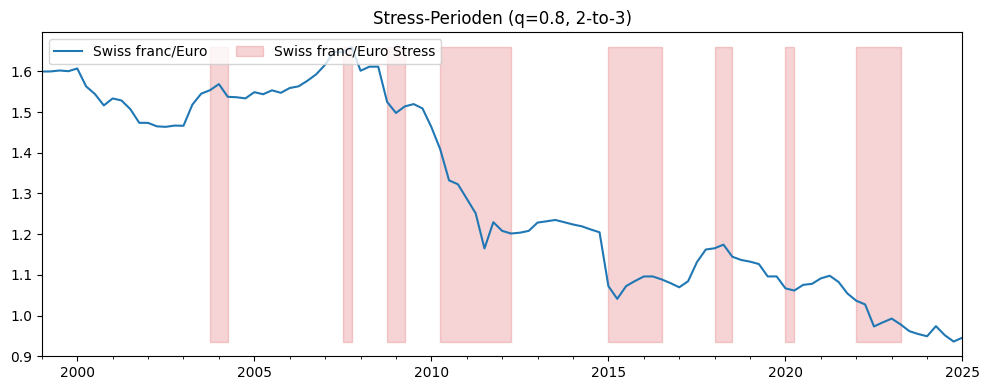

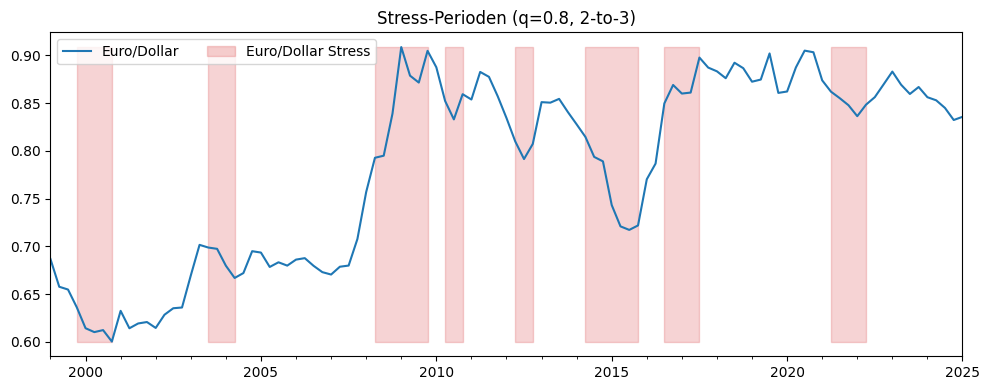

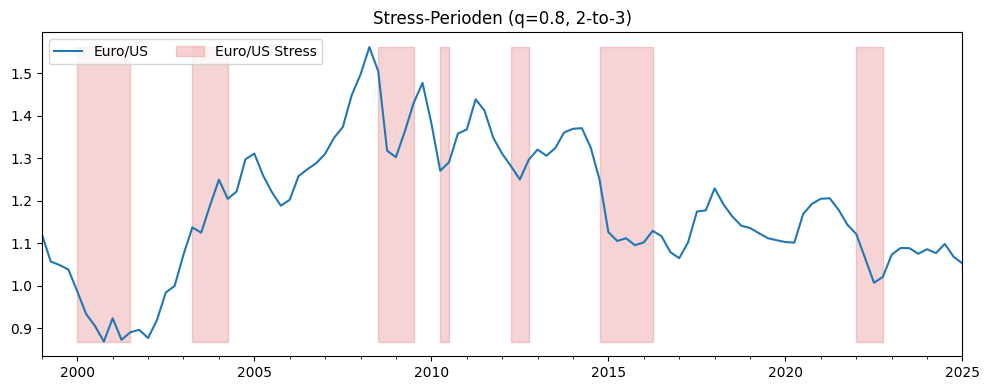

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# Hilfsfunktionen: Returns/Transform, EWMA-Fallback, GARCH
# =========================================================
def to_returns(series: pd.Series, ret_horizon=4, use_logdiff=True) -> pd.Series:
    """
    Wandelt Niveaus in (YoY-)Returns um.
    Standard: Log-Differenzen (YoY bei Quartalsdaten -> ret_horizon=4).
    Wenn <=0-Werte vorkommen, fällt auf pct_change zurück.
    """
    s = series.astype(float)
    if use_logdiff and (s > 0).all():
        return np.log(s).diff(ret_horizon)
    else:
        return s.pct_change(ret_horizon)

def ewma_vol(returns: pd.Series, lam=0.94) -> pd.Series:
    """
    RiskMetrics-ähnliche EWMA-Volatilität als Fallback.
    """
    var = returns.pow(2)
    ewma_var = var.ewm(alpha=1 - lam, adjust=False, min_periods=1).mean()
    return np.sqrt(ewma_var)

def fit_garch_series(returns: pd.Series, dist="t"):
    """
    Fit eines GARCH(1,1) je Serie.
    Gibt bedingte Volatilität (sigma_t), standardisierte Residuen (std_resid),
    und Param-Infos zurück. Fällt bei Fehlern auf EWMA+z-Approx zurück.
    """
    r = returns.dropna()
    if r.empty:
        idx = returns.index
        return (pd.Series(index=idx, dtype=float),
                pd.Series(index=idx, dtype=float),
                {'model': 'NA'})

    # Skalierung für numerische Stabilität (z. B. in Prozentpunkten)
    scale = 100.0
    try:
        from arch import arch_model
        am = arch_model(r * scale, vol='GARCH', p=1, q=1, mean='Constant', dist=dist)
        res = am.fit(disp='off')
        sigma = pd.Series(res.conditional_volatility.values / scale, index=r.index, name='garch_vol')
        std_resid = pd.Series(res.std_resid, index=r.index, name='std_resid')
        params = res.params.to_dict()
        # Persistenzindikator (alpha+beta)
        alpha = params.get('alpha[1]', np.nan)
        beta = params.get('beta[1]', np.nan)
        params['persistence'] = (alpha if pd.notna(alpha) else 0) + (beta if pd.notna(beta) else 0)
        params['model'] = 'GARCH(1,1)'
        params['dist'] = dist
        return sigma, std_resid, params

    except Exception as e:
        # Fallback: EWMA-Vol + z-Approx der Residuen
        sigma = ewma_vol(r)
        mu = r.rolling(20, min_periods=5).mean()
        std_resid = (r - mu).divide(sigma.replace(0, np.nan))
        params = {'model': 'EWMA_fallback', 'lambda': 0.94, 'error': str(e)}
        return sigma, std_resid, params

def rolling_drawdown(levels: pd.Series, window=20):
    """
    Drawdown relativ zu rollierendem Maximum (vermeidet Artefakte des globalen Maximums).
    """
    roll_max = levels.rolling(window, min_periods=1).max()
    return levels / roll_max - 1


# =========================================================
# Deine Funktion – jetzt mit GARCH-Volatilität integriert
# =========================================================
def compute_stress_metrics(df, window=4, ret_horizon=4, dd_window=20, eps=1e-8,
                           use_logdiff=True, use_garch=True, dist='t'):
    """
    window: Rollfenster (nur noch für z-Approx im Fallback verwendet)
    ret_horizon: 4 -> YoY-Veränderung für Quartalsdaten
    dd_window: Fenster für rollierendes Maximum (z. B. 20 Quartale = 5 Jahre)
    use_logdiff: True -> Log-Differenzen, sonst pct_change
    use_garch: True -> GARCH(1,1) für Volatilität + standardisierte Residuen
    dist: Fehlerverteilung im GARCH ('normal', 't', 'skewt')
    """
    X = df.select_dtypes(include=[np.number]).copy()
    idx = X.index

    # Returns (Makro: oft YoY-Log-Diffs sinnvoll)
    returns = X.apply(lambda s: to_returns(s, ret_horizon=ret_horizon, use_logdiff=use_logdiff))

    # Volatilität & Tail-Metrik (std_resid)
    vol = pd.DataFrame(index=idx, columns=X.columns, dtype=float)
    z_like = pd.DataFrame(index=idx, columns=X.columns, dtype=float)  # std_resid aus GARCH (Tail-Info)

    # GARCH (oder Fallback) pro Spalte
    if use_garch:
        for col in X.columns:
            sigma, std_resid, _params = fit_garch_series(returns[col], dist=dist)
            vol[col] = sigma.reindex(idx)
            z_like[col] = std_resid.reindex(idx)
    else:
        # klassisch: Rolling-Std & Z-Scores (wie bisher)
        vol = returns.rolling(window, min_periods=window).std()
        mu  = returns.rolling(window, min_periods=window).mean()
        sigma = returns.rolling(window, min_periods=window).std().clip(lower=eps)
        z_like = (returns - mu) / sigma

    # Drawdown relativ zu rollierendem Max der Niveaus
    dd = X.apply(lambda s: rolling_drawdown(s, window=dd_window))

    # Benennung wie bei dir: 'volatility', 'zscore', 'drawdown'
    # -> zscore wird hier (bei use_garch=True) mit standardisierten Residuen befüllt
    return {'volatility': vol, 'drawdown': dd, 'zscore': z_like}



def identify_stress_periods(metrics, q=0.8, require_n=1):
    vol = metrics['volatility']
    dd  = metrics['drawdown']
    z   = metrics['zscore']

    vol_th = vol.quantile(q)
    dd_th  = dd.quantile(1 - q)
    z_th   = z.quantile(1 - q)

    c_vol = vol.gt(vol_th)   # hohe (GARCH-)Volatilität
    c_dd  = dd.lt(dd_th)     # tiefer Drawdown
    c_z   = z.lt(z_th)       # negative Ausreißer (Tail-Events)

    cond_sum = c_vol.astype(int) + c_dd.astype(int) + c_z.astype(int)
    stress = cond_sum >= require_n
    return stress

# (Optional) Mindestdauer-Regel, um Ein-Punkt-Spikes zu vermeiden
def enforce_min_duration(flags: pd.DataFrame, min_len=2):
    out = flags.copy()
    for col in flags.columns:
        s = flags[col].fillna(False).astype(bool)
        if s.any():
            grp = (s != s.shift()).cumsum()
            lengths = s.groupby(grp).transform('sum')
            out[col] = s & (lengths >= min_len)
        else:
            out[col] = s
    return out


def plot_stress(df, stress_flags, title_suffix=""):
    years = pd.date_range(start='1999', periods=len(df), freq='QE')  # wie bei dir
    df_indexed = df.set_index(years)
    stress_flags_indexed = stress_flags.set_index(years)

    ax = df_indexed.plot(figsize=(10,4), lw=1.5)
    y_min, y_max = df_indexed.min().min(), df_indexed.max().max()

    # Schattierung pro Spalte
    for col in df_indexed.columns:
        if col in stress_flags_indexed.columns:
            ax.fill_between(df_indexed.index, y_min, y_max,
                            where=stress_flags_indexed[col].fillna(False),
                            color='tab:red', alpha=0.2, label=f'{col} Stress')
    ax.set_title(f"Stress-Perioden {title_suffix}".strip())
    ax.set_xlabel("")
    ax.legend(loc='upper left', ncol=2)
    plt.tight_layout()
    plt.show()



df = pd.read_csv('/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Data/germany_macro.csv', parse_dates=False)

# GARCH-basierte Metriken berechnen (t-Verteilung, YoY-Log-Diffs)
metrics = compute_stress_metrics(df,
                                 window=4,
                                 ret_horizon=4,
                                 dd_window=8,
                                 use_logdiff=True,
                                 use_garch=True,
                                 dist='t')

# Schwellen & Stress-Flags (z.B. streng: q=0.95, mind. 2 von 3 Kriterien)
q = 0.8
stress_flags = identify_stress_periods(metrics, q=q, require_n=1)

# Optional: Mindestdauerregel (z. B. min. 2 Perioden am Stück)
stress_flags = enforce_min_duration(stress_flags, min_len=2)

# Plot je Spalte
for col in df.select_dtypes(include=[np.number]).columns:
    plot_stress(df[[col]], stress_flags[[col]], title_suffix=f"(q={q}, 2-to-3)")

In [22]:
stress_flags.sum()

,0
GDP,14
Unemployment,16
Inflation,16
InterestRate,16
Swiss franc/Euro,15
Euro/Dollar,15
Euro/US,15
